<a href="https://colab.research.google.com/github/ManavSarkar/Weight-Prediction-using-Machine-Learning/blob/deep-feature-extraction/Deep_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
! rm -rf datasets

In [51]:
! git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [69]:
! git remote set-url origin https://github.com/ManavSarkar/Weight-Prediction-using-Machine-Learning.git

In [71]:
! git config --global user.name "Manav Sarkar"
! git config --global user.email "manavsarkar07@gmail.com"

In [70]:
! git switch -c deep-feature-extraction

fatal: A branch named 'deep-feature-extraction' already exists.


In [72]:
! git pull https://github.com/ManavSarkar/Weight-Prediction-using-Machine-Learning.git

fatal: could not read Username for 'https://github.com': No such device or address


In [2]:
dataset_path = 'datasets/data.csv'
import pandas as pd

df = pd.read_csv(dataset_path)


In [3]:
df.head()

,img_name,sex,age,height,weight
0,000002_F_18_165100_8482178.jpg,0,18,1.6510,84.82178
1,000003_F_18_170180_3991613.jpg,0,18,1.7018,39.91613
2,000003_F_18_170180_7257478.jpg,0,18,1.7018,72.57478
3,000004_F_22_157480_5606402.jpg,0,22,1.5748,56.06402
4,000004_F_22_157480_6245967.jpg,0,22,1.5748,62.45967


In [4]:
# first getting ResNet 101 model from torch
import torch
resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.10.0


In [5]:
# replacing last layer with 15 features instead of 1000
import torch
import torch.nn as nn
resnet_model.fc = nn.Linear(2048, 15)

In [6]:
# using the adam optimizer with learning rate of 0.0001 first and second momentum of 0.9 and 0.999 respectively
import torch.optim as optim
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.001)

In [7]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# scaling the longer side of image to 224 and pad the shorter size with zeroes to match 224x224
from PIL import Image, ImageOps

def scale_and_pad(img):
    width, height = img.size
    if width > height:
        scale = 224 / width
        new_height = int(height * scale)
        img = img.resize((224, new_height))
        padding = (224 - new_height) // 2
        img = ImageOps.expand(img, (0, padding, 0, 224 - new_height - padding))
    else:
        scale = 224 / height
        new_width = int(width * scale)
        img = img.resize((new_width, 224))
        padding = (224 - new_width) // 2
        img = ImageOps.expand(img, (padding, 0, 224 - new_width - padding, 0))
    return img




In [9]:
# transform an image from datasets/images/ to a tensor
from PIL import Image
img_path = 'datasets/Images/002274_M_35_175260_12337713.jpg'
img = Image.open(img_path)
img = scale_and_pad(img)


In [10]:
# normalized with mean values[0.485, 0.456, 0.406] 
# and standard deviation values[0.229, 0.224, 0.225]
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                         
                            std=[0.229, 0.224, 0.225])
])

img = transform(img)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


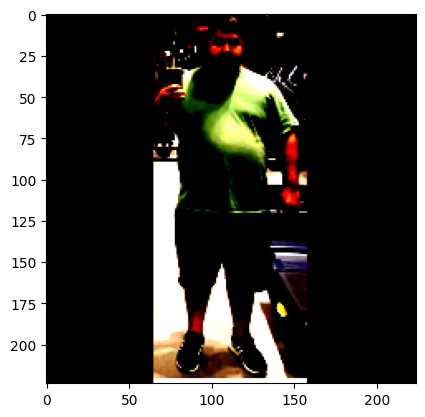

In [11]:
# plot the image
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))


In [12]:
# load all images from datasets/images/ and convert them to tensors, file names are in df.img_name
img_tensors = []

for img_name in df.img_name:
    img_path = 'datasets/Images/' + img_name
    img = Image.open(img_path)
    img = scale_and_pad(img)
    img = transform(img)
    img_tensors.append(img)

In [13]:
len(img_tensors)

3884

In [14]:
# train test split
from sklearn.model_selection import train_test_split
train_img_tensors, test_img_tensors, train_labels, test_labels = train_test_split(img_tensors, df.iloc[:, 1:].values, test_size=0.2, random_state=42)


In [15]:
# train the resnet model on the train_img_tensors and train_labels
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [16]:

resnet_model = resnet_model.to(device)
criterion = nn.MSELoss()

train_losses = []

# batch size of 64 and 50 epochs
for epoch in range(50):
    running_loss = 0.0
    for i in range(0, len(train_img_tensors), 64):
        batch_img_tensors = train_img_tensors[i:i+64]
        batch_labels = train_labels[i:i+64]
        batch_img_tensors = torch.stack(batch_img_tensors).to(device)
        batch_labels = torch.tensor(batch_labels, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        outputs = resnet_model(batch_img_tensors)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss)
    print('Epoch', epoch, 'loss', running_loss)

: 

: 